In [1]:
%load_ext autotime

time: 980 µs


In [2]:
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pylab as plt
from collections import Counter
from sklearn.manifold import TSNE

time: 4.79 s


In [3]:
age_seq = pickle.load(open("../../DATA/age_seq","rb"))
sex_seq = pickle.load(open("../../DATA/sex_seq","rb"))

time: 41.5 ms


In [4]:
code_seq_2013 = pickle.load(open("../../DATA/code_seq_2013","rb"))
cost_seq_2013 = pickle.load(open("../../DATA/cost_seq_2013","rb"))
date_seq_2013 = pickle.load(open("../../DATA/date_seq_2013","rb"))
util_seq_2013 = pickle.load(open("../../DATA/util_seq_2013","rb"))

time: 14.4 s


In [5]:
code_seq_2014 = pickle.load(open("../../DATA/code_seq_2014","rb"))
cost_seq_2014 = pickle.load(open("../../DATA/cost_seq_2014","rb"))
date_seq_2014 = pickle.load(open("../../DATA/date_seq_2014","rb"))
util_seq_2014 = pickle.load(open("../../DATA/util_seq_2014","rb"))

time: 18.4 s


In [6]:
TMAE_Embedding = pickle.load(open("../../MODELS/TMAE/Embeddings/TMAE_Embedding_100","rb"))

time: 253 ms


In [7]:
from sklearn.metrics import silhouette_score

def calculate_WSS(points, kmax):
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
        sse.append(curr_sse)
    return sse

def calculate_SIL(x, kmax = 10):
    sil = []
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(x)
        labels = kmeans.labels_
        sil.append(silhouette_score(x, labels, metric = 'euclidean'))
    return sil

time: 3.34 ms


In [8]:
from sklearn.cluster import KMeans
from collections import Counter

time: 120 ms


In [9]:
icd3_seq = []

for p in code_seq_2013:
    p_codes = []
    for v in p:
        new_v = []
        for c in v:
            c = c[:5]
            new_v.append(c)
        p_codes.extend(list(set(new_v)))
    icd3_seq.append(p_codes)

time: 3.16 s


In [10]:
def select_diag(icd3_code, freq=1):
    idx_seq = []
    for i, p_code in enumerate(icd3_seq):
        if icd3_code in p_code and Counter(p_code)[icd3_code]>=freq:
            idx_seq.append(i)
    return idx_seq

time: 1.06 ms


In [11]:
idx = select_diag("D_299", freq=1)
len(idx)

509

time: 244 ms


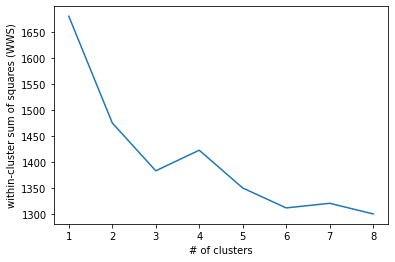

time: 1.25 s


In [23]:
kmax = 8
points = TMAE_Embedding[idx]
sse = calculate_WSS(points, kmax=kmax)
plt.plot(range(1, kmax+1), sse)
plt.xlabel("# of clusters")
plt.ylabel("within-cluster sum of squares (WWS)")
plt.savefig("autotis", dpi=300)

In [14]:
from sklearn.cluster import KMeans

n=3
kmeans = KMeans(n_clusters=n, random_state=0).fit(TMAE_Embedding[idx])
group_id = {i: np.where(kmeans.labels_ == i)[0] for i in range(n)}

time: 240 ms


In [15]:
Counter(kmeans.labels_)

Counter({0: 150, 2: 133, 1: 226})

time: 50.2 ms


In [16]:
def cluster_output(seq_2013, seq_2014, k=2, mean_flag=False):
    for i in range(k):
        print("CLUSTERS:",i)
        cluster_idx = np.where(kmeans.labels_ == i)[0]
        if mean_flag: 
            print("2013:", np.mean(seq_2013[cluster_idx]))
            print("2014:", np.mean(seq_2014[cluster_idx]))
        else:
            print("2013:", np.median(seq_2013[cluster_idx]))
            print("2014:", np.median(seq_2014[cluster_idx]))
        print()

time: 3.84 ms


In [17]:
def generate_cost_seqs(cost_seq, util_seq):
    RX_cost, IP_cost, OP_cost = [],[],[]
    for p_cost, p_util in zip(cost_seq, util_seq):
        RX_, IP_, OP_ = 0, 0, 0
        for cost, util in zip(p_cost, p_util):
            if "RX" in util:
                RX_ += cost
            elif "IP" in util:
                IP_ += cost
            else:
                OP_ += cost
        RX_cost.append(RX_)
        IP_cost.append(IP_)
        OP_cost.append(OP_)
    return np.array(RX_cost), np.array(IP_cost), np.array(OP_cost), np.array([sum(k) for k in cost_seq])

def generate_util_seqs(util_seq):
    RX_visit, IP_visit, OP_visit = [],[],[]
    for p_util in util_seq:
        RX_, IP_, OP_ = 0, 0, 0
        for util in p_util:
            if "RX" in util:
                RX_ += 1
            elif "IP" in util:
                IP_ += 1
            else:
                OP_ += 1
        RX_visit.append(RX_)
        IP_visit.append(IP_)
        OP_visit.append(OP_)
    return np.array(RX_visit), np.array(IP_visit), np.array(OP_visit)



time: 4.84 ms


In [18]:
RX_2013, IP_2013, OP_2013, total_2013 = generate_cost_seqs(cost_seq_2013, util_seq_2013)
RX_2014, IP_2014, OP_2014, total_2014 = generate_cost_seqs(cost_seq_2014, util_seq_2014)

time: 2.89 s


In [19]:
cluster_output(RX_2013[idx], RX_2014[idx], k=n)

CLUSTERS: 0
2013: 86.80000000000001
2014: 115.345

CLUSTERS: 1
2013: 38.155
2014: 32.085

CLUSTERS: 2
2013: 1139.58
2014: 1168.44

time: 5.65 ms


In [20]:
cluster_output(IP_2013[idx], IP_2014[idx], k=n)

CLUSTERS: 0
2013: 0.0
2014: 0.0

CLUSTERS: 1
2013: 0.0
2014: 0.0

CLUSTERS: 2
2013: 0.0
2014: 0.0

time: 4.04 ms


In [21]:
cluster_output(OP_2013[idx], OP_2014[idx], k=n)

CLUSTERS: 0
2013: 1014.5550000000001
2014: 537.46

CLUSTERS: 1
2013: 1071.775
2014: 849.1949999999999

CLUSTERS: 2
2013: 640.52
2014: 425.38

time: 3.4 ms


In [22]:
cluster_output(total_2013[idx], total_2014[idx], k=n)

CLUSTERS: 0
2013: 1355.89
2014: 884.705

CLUSTERS: 1
2013: 1221.0900000000001
2014: 1071.1650000000002

CLUSTERS: 2
2013: 2087.6699999999996
2014: 1972.36

time: 11.8 ms


In [23]:
RX_2013, IP_2013, OP_2013 = generate_util_seqs(util_seq_2013)
RX_2014, IP_2014, OP_2014 = generate_util_seqs(util_seq_2014)

time: 756 ms


In [24]:
cluster_output(RX_2013[idx], RX_2014[idx], k=n, mean_flag=True)

CLUSTERS: 0
2013: 5.52
2014: 7.026666666666666

CLUSTERS: 1
2013: 3.1194690265486726
2014: 3.730088495575221

CLUSTERS: 2
2013: 10.849624060150376
2014: 12.075187969924812

time: 26 ms


In [25]:
cluster_output(IP_2013[idx], IP_2014[idx], k=n, mean_flag=True)

CLUSTERS: 0
2013: 0.02
2014: 0.03333333333333333

CLUSTERS: 1
2013: 0.008849557522123894
2014: 0.008849557522123894

CLUSTERS: 2
2013: 0.045112781954887216
2014: 0.007518796992481203

time: 13 ms


In [26]:
cluster_output(OP_2013[idx], OP_2014[idx], k=n, mean_flag=True)

CLUSTERS: 0
2013: 9.326666666666666
2014: 9.566666666666666

CLUSTERS: 1
2013: 12.216814159292035
2014: 13.420353982300885

CLUSTERS: 2
2013: 8.105263157894736
2014: 6.706766917293233

time: 42.4 ms


In [27]:
for i in range(n):
    print("CLUSTERS:",i)
    cluster_idx = np.where(kmeans.labels_ == i)[0]
    print("age", np.mean(np.array(age_seq)[idx][cluster_idx]))
    
    print(Counter(np.array(sex_seq)[idx][cluster_idx]))
    print([i/len(cluster_idx) for i in Counter(np.array(sex_seq)[idx][cluster_idx]).values()])
    print()




CLUSTERS: 0
age 9.946666666666667
Counter({'M': 121, 'F': 29})
[0.8066666666666666, 0.19333333333333333]

CLUSTERS: 1
age 5.761061946902655
Counter({'M': 178, 'F': 48})
[0.7876106194690266, 0.21238938053097345]

CLUSTERS: 2
age 10.443609022556391
Counter({'M': 109, 'F': 24})
[0.18045112781954886, 0.8195488721804511]

time: 224 ms


In [28]:
pcode_seq = []

for p in code_seq_2013:
    pcode = []
    for v in p:
        for c in v:
            pcode.append(c)
    pcode_seq.append(pcode)
    
pcode_seq = [pcode_seq[i] for i in idx]
len(pcode_seq)

509

time: 1.9 s


In [29]:
count_list = []
for i in range(n):
    print("CLUSTERS:",i)
    cluster_idx = np.where(kmeans.labels_ == i)[0]
    pcode_seq_cluster = [pcode_seq[i] for i in cluster_idx]
    codes = [c for p in pcode_seq_cluster for c in p]
    count_list.append(Counter(codes).most_common(10))

CLUSTERS: 0
CLUSTERS: 1
CLUSTERS: 2
time: 12.1 ms


In [30]:
count_list[0]

[('P_99213', 213),
 ('D_299.00', 158),
 ('P_510', 154),
 ('P_99214', 142),
 ('P_D1208', 125),
 ('P_D1120', 111),
 ('P_D0120', 101),
 ('D_V20.2', 96),
 ('D_299.80', 95),
 ('D_314.01', 62)]

time: 6.31 ms


In [31]:
count_list[1]

[('D_299.00', 860),
 ('P_440', 610),
 ('D_V57.3', 567),
 ('P_99213', 383),
 ('D_315.32', 292),
 ('P_510', 235),
 ('P_99214', 175),
 ('D_V20.2', 153),
 ('P_450', 149),
 ('P_430', 142)]

time: 9.22 ms


In [32]:
count_list[2]

[('P_99213', 291),
 ('D_314.01', 282),
 ('M_RISPERIDONE', 225),
 ('P_99214', 192),
 ('M_METHYLPHENIDATE ER', 170),
 ('M_DEXTROAMPHETAMINE-AMPHETAMINE', 153),
 ('M_CLONIDINE HCL', 145),
 ('D_299.80', 138),
 ('M_INTUNIV', 111),
 ('D_299.00', 99)]

time: 3.98 ms


In [18]:
def generate_plot(Embedding, labels, color_dic, legend, title):
    tsne_model = TSNE(n_components=2, init='pca', random_state=23)
    new_values = tsne_model.fit_transform(Embedding)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    for i in range(len(x)):
        plt.scatter(x[i],y[i], color = color_dic[labels[i]], alpha=0.4)
    for i in range(len(color_dic)):
        plt.scatter(0,0, color=color_dic[i], label=legend[i], alpha=0.4)
    plt.legend()
    
    plt.xticks([])
    plt.yticks([])
    plt.savefig(title)
    plt.show()

time: 3.89 ms


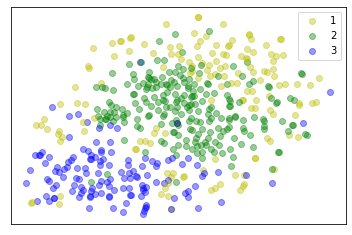

time: 11.2 s


In [20]:
# color_dic = {0:"y", 1:"g", 2:"b", 3:"r",4:"black"}
# legend = ["1", "2", "3", "4","5"]

color_dic = {0:"y", 1:"g", 2:"b"}
legend = ["1", "2", "3"]

generate_plot(TMAE_Embedding[idx], kmeans.labels_, color_dic, legend, title="autotis_clusters")

In [ ]:
# diag2cat = pickle.load(open("../DATA/CCS/diag2cat","rb"))

# ccs_seq_2013 = []
# for p in code_seq_2013:
#     p_ccs = []
#     for v in p:
#         v_ccs = []
#         for c in v:
#             if c in diag2cat:
#                 new_c = diag2cat[c]
#                 v_ccs.append(new_c)
#         p_ccs.extend(list(set(v_ccs)))
#     ccs_seq_2013.append(p_ccs)
    
# def select_diag(code, code_seq, freq=1):
#     idx_seq = []
#     for i, p_code in enumerate(code_seq):
#         if code in p_code and Counter(p_code)[code]>=freq:
#             idx_seq.append(i)
#     return idx_seq

# idx = select_diag("49", ccs_seq_2013, freq=1)
# len(idx)

# d1_idx = select_diag("128", ccs_seq_2013, freq=3)[:1000]
# len(d1_idx)